In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [7]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
AAPL = pd.read_csv('AAPL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103607600
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,157859100
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,110691500


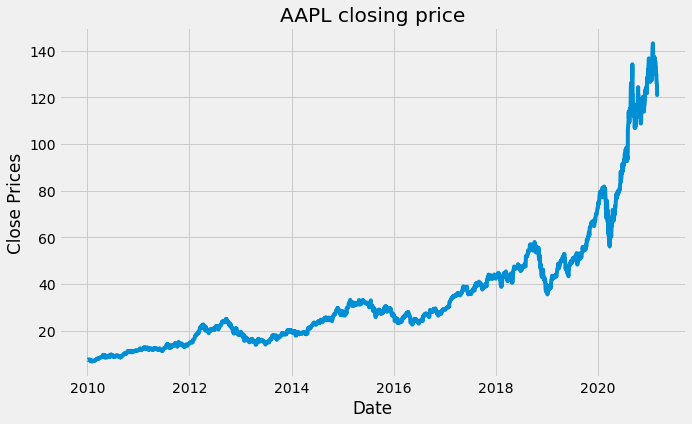

In [9]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(AAPL['Close'])
plt.title('AAPL closing price')
plt.show()

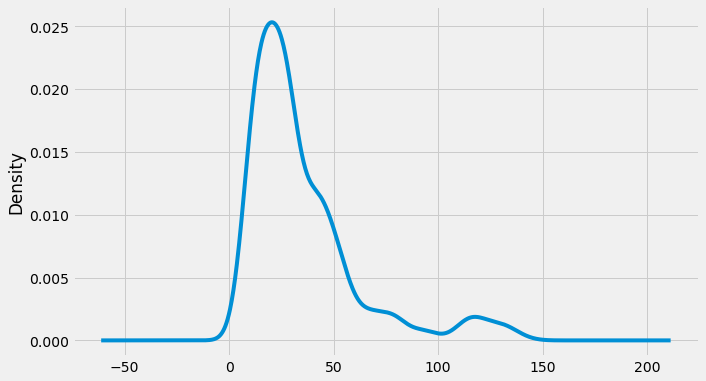

In [12]:
#Distribution of the dataset
AAPL['Close'].plot(kind='kde')

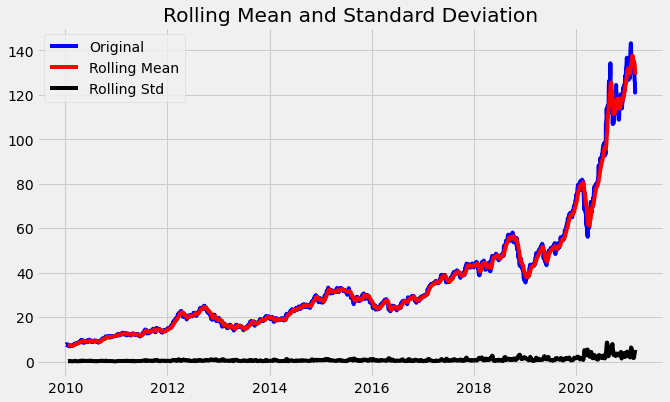

Results of dickey fuller test
Test Statistics                   1.980240
p-value                           0.998647
No. of lags used                 27.000000
Number of observations used    2779.000000
critical value (1%)              -3.432705
critical value (5%)              -2.862581
critical value (10%)             -2.567324
dtype: float64


In [13]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(AAPL['Close'])

Th p-value shows this is not stationary right now, we need to make it stationary.

<Figure size 720x432 with 0 Axes>

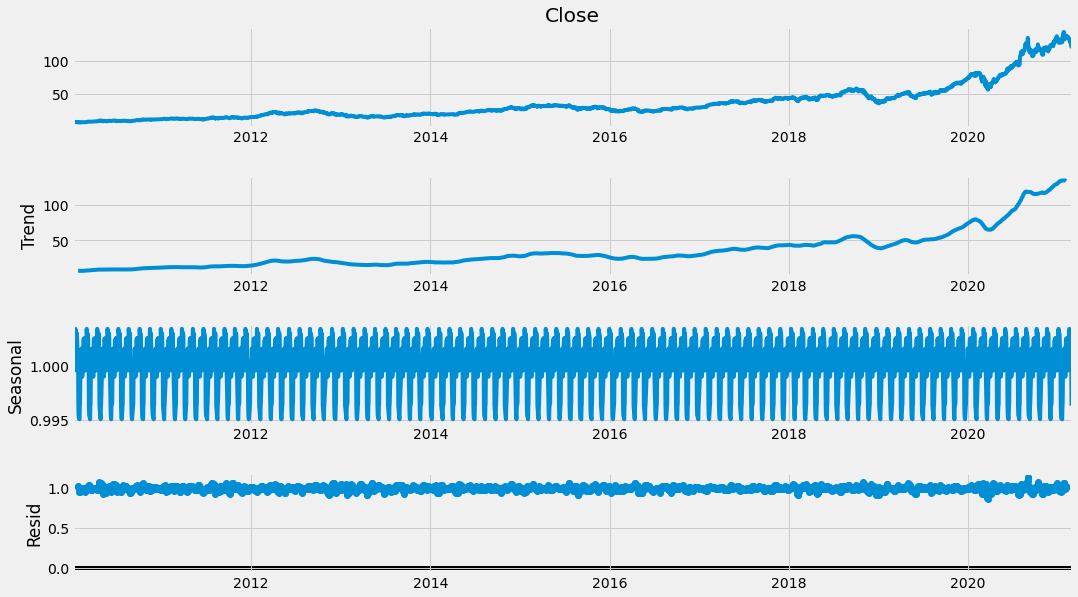

In [15]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(AAPL['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


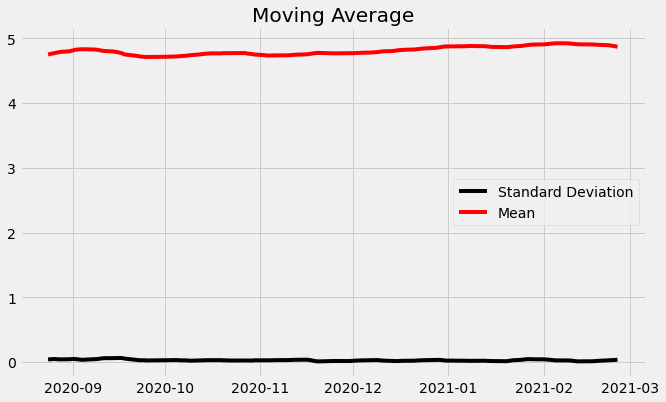

In [122]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#Set Date Range
df_log = np.log(AAPL['Close'][2667:-1])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

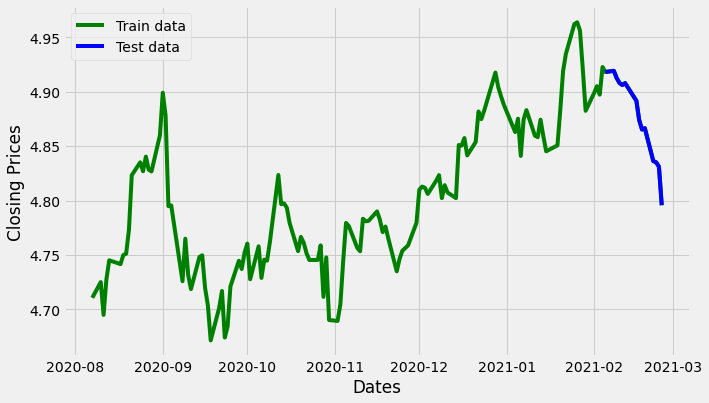

In [123]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [136]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [125]:
#Modeling
# Build Model
#train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')
#test_data.index = pd.DatetimeIndex(test_data.index).to_period('D')
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  121
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 278.522
Method:                           css   S.D. of innovations              0.024
Date:                Mon, 22 Mar 2021   AIC                           -553.044
Time:                        16:21:03   BIC                           -547.452
Sample:                             1   HQIC                          -550.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.733      0.463      -0.003       0.006


/Users/jasmineyoung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jasmineyoung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [128]:
# Forecast
fc, se, conf = fitted.forecast(14, alpha=0.05)  # 95% conf

In [129]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

In [130]:
train_data.index = train_data.index.astype('datetime64[ns]')
#AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')

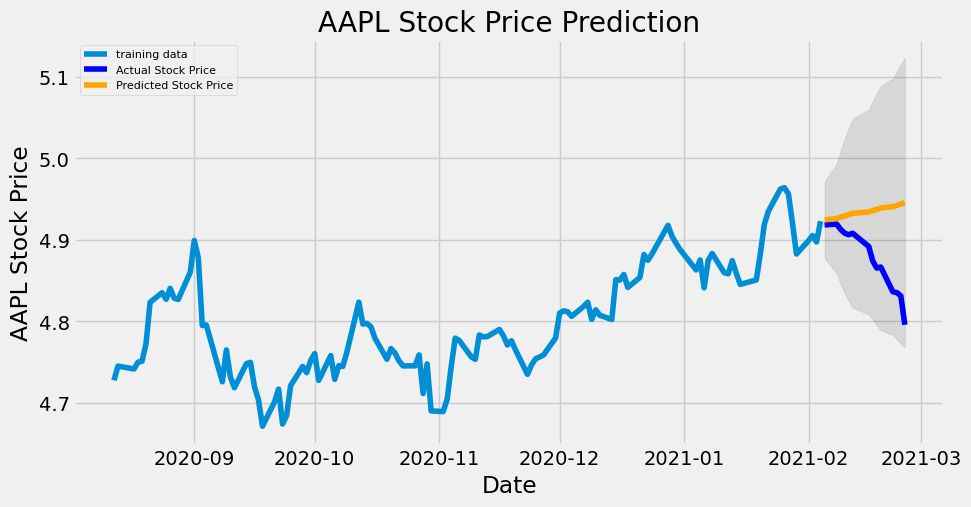

In [131]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
#train_data2 = pd.DataFrame(train_data)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [132]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.005389863922831923
MAE: 0.05860724116267673
RMSE: 0.07341569261971123
MAPE: 0.012090261004913961


In [91]:
test_data

Date
2021-02-05    4.918228
2021-02-08    4.919324
2021-02-09    4.912728
2021-02-10    4.908159
2021-02-11    4.906237
2021-02-12    4.908012
2021-02-16    4.891777
2021-02-17    4.873975
2021-02-18    4.865301
2021-02-19    4.866534
2021-02-22    4.836282
2021-02-23    4.835170
2021-02-24    4.831110
2021-02-25    4.795708
Name: Close, dtype: float64

3.8 % MAPE means we are about 96.2% accurate at predicting (the next 15 days? unsure about this one)